In [39]:
import torch
from torch.utils.data import DataLoader
from data_utils import CustomTransform
import numpy as np
import wandb
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
import tqdm
import faiss
import json
import os
from coco_utils import COCODataset, COCOforTripletNetwork, create_image_category_pairs
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import umap
from sklearn.decomposition import PCA
import pickle
import matplotlib.cm as cm

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
config = {
    'IMG_WIDTH': 256,
    'IMG_HEIGHT': 256,
    'ROOT_DIRECTORY': '/export/home/mcv/datasets/C5/COCO',
    'batch_size': 32,
    'num_workers': 2,
    'epochs': 15,
    'learning_rate': 0.0001,
    'n_neighbors': 5,
    'type_model': 'triplet',
    'classifier': 'knn',
    'n_neighbors': 5,
    'metric': 'euclidean',
    'voronoi_cells': 64,
    'lookup_cells': 8,
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

torch.manual_seed(123); # seed for reproductibility

In [41]:
transform_train = CustomTransform(config, mode='train')
transform_test = CustomTransform(config, mode='test')

# File containing object-Images relationships
with open(os.path.join(config["ROOT_DIRECTORY"], "mcv_image_retrieval_annotations.json"), "r") as f:
    retrieval_annotations = json.load(f)

# File containing images information (file_name and instances bboxes and labels)
with open(os.path.join(config["ROOT_DIRECTORY"], "instances_train2014.json"), "r") as f:
    instances_info_train = json.load(f)

with open(os.path.join(config["ROOT_DIRECTORY"], "instances_val2014.json"), "r") as f:
    instances_info_val = json.load(f)

if True:
    with open("image_category_pairs.json", "r") as f:
        image_category_pairs = json.load(f)
else:
    # If "image_category_pairs.json" does not exist
    create_image_category_pairs(retrieval_annotations["train"])
    

In [42]:
database_images = []
for image_ids in retrieval_annotations["database"].values():
    database_images += image_ids
database_images = list(set(database_images))
database_images_image_category_pairs = [i for i in image_category_pairs if i["image_id"] in database_images]

database = COCODataset(
    root=config['ROOT_DIRECTORY'],
    image_folder="train2014",
    instances_info=instances_info_train, 
    transforms=transform_train,
    image_category_pairs=database_images_image_category_pairs)

In [43]:
# Merge "val" and "test" queries
queries_annotations = {}
for k, v in retrieval_annotations["val"].items():
    queries_annotations[k] = v.copy()
for k, v in retrieval_annotations["test"].items():
    queries_annotations[k] += v.copy()

queries = COCODataset(
    root=config['ROOT_DIRECTORY'],
    image_folder="val2014", 
    instances_info=instances_info_val, 
    transforms=transform_train,
    annotations=queries_annotations,
    is_queries=True)

In [44]:
def query_collator(original_batch):
    """
        Format COCO data to Faster RCNN's input format.
    """
    images = []
    targets = []
    for samples in original_batch:
        images.append(samples[0])
        targets.append(samples[1])
    return images, targets

dataloader_queries = DataLoader(queries, batch_size=config['batch_size'], collate_fn=query_collator, shuffle=False, num_workers=config["num_workers"])
dataloader_database = DataLoader(database, batch_size=config['batch_size'], shuffle=False, num_workers=config["num_workers"])

In [45]:
model = COCOforTripletNetwork()
model.load_state_dict(torch.load('pretrained/best_model_cocotriplet_final_relu_smallerLR.pth', map_location=config['device']))
model.to(config['device']);

In [46]:
# Define a function to extract features from an image
def extract_features(loader, model, device, queries=False):
    model.eval()
    with torch.no_grad():    
        features, labels = [], []
        for img, label in tqdm.tqdm(loader, total=len(loader), desc='Extracting features'):
            if queries:
                img = torch.stack(img)
                features.append(model(img.to(device)).cpu().detach().numpy())
                labels.extend(label)
            else: 
                features.append(model(img.to(device)).cpu().detach().numpy())
                labels.append(label)
    if queries:
        return np.concatenate(features).astype('float32'), labels
    else:
        return np.concatenate(features).astype('float32'), np.concatenate(labels)


# k-NN Classifier for Image Retrieval
class ImageRetrievalSystem:
    def __init__(self, model, database_loader, query_loader, config):
        self.model = model
        self.database_loader = database_loader
        self.query_loader = query_loader
        self.device = config['device']

        self.dim = 1024
        self.classifier_type = config['classifier']
        self.n_neighbors = config['n_neighbors']

        if self.classifier_type == 'knn':
            self.classifier = NearestNeighbors(n_neighbors=config['n_neighbors'], metric=config['metric'])
        else:
            self.classifier = faiss.IndexIVFFlat(faiss.IndexFlatL2(self.dim), self.dim, config['voronoi_cells'])
            self.classifier.nprobe = config['lookup_cells']

    def fit(self):

        features, self.train_labels = extract_features(self.database_loader, self.model, self.device)
        
        print('Fitting the classifier...')
        if self.classifier_type == 'knn':
            self.classifier.fit(features, self.train_labels)
        else:
            self.classifier.train(features)
            self.classifier.add(features)

    def retrieve(self):

        features, labels = extract_features(self.query_loader, self.model, self.device, queries=True)
        
        print('Retrieving images...')
        if self.classifier_type == 'knn':
            _, predictions = self.classifier.kneighbors(features, return_distance=True)
        else:
            _, predictions = self.classifier.search(features, self.n_neighbors)
        
        return predictions, labels

In [66]:
def evaluate(predictions, labels):

    # Prec@1
    prec_at_1 = np.mean([1 if predictions[i, 0] in labels[i] else 0 for i in range(predictions.shape[0])])

    # Prec@5
    prec_at_5 = np.mean([np.any([1 if predictions[i, j] in labels[i] else 0 for j in range(config['n_neighbors'])]) for i in range(predictions.shape[0])])

    # Initialize list to store average precision for each query
    average_precisions = []

    # Compute binary relevance arrays and calculate average precision for each query
    for i in range(predictions.shape[0]):
        # Convert true label into binary format for each prediction
        binary_relevance = np.array([1 if label in labels[i] else 0 for label in predictions[i]])
        
        # Ensure there is at least one positive class to avoid division by zero in AP score calculation
        if np.sum(binary_relevance) > 0:
            # Compute the average precision for the current query
            ap_score = average_precision_score(binary_relevance, np.ones_like(binary_relevance))
            average_precisions.append(ap_score)

    # Compute mean Average Precision (mAP) by averaging all the AP scores
    mean_ap = np.mean(average_precisions)

    return prec_at_1, prec_at_5, mean_ap

In [48]:
pipeline = ImageRetrievalSystem(model, dataloader_database, dataloader_queries, config)

In [49]:
pipeline.fit()

Extracting features:   0%|          | 0/62 [00:00<?, ?it/s]

Extracting features: 100%|██████████| 62/62 [01:45<00:00,  1.70s/it]

Fitting the classifier...


In [69]:
predictions, labels = pipeline.retrieve()
predictions = pipeline.train_labels[predictions]

Extracting features:   0%|          | 0/94 [00:00<?, ?it/s]

Extracting features: 100%|██████████| 94/94 [02:17<00:00,  1.46s/it]

Retrieving images...


In [70]:
prec_at_1, prec_at_5, mean_ap = evaluate(predictions, labels)

In [71]:
prec_at_1, prec_at_5, mean_ap

(0.17466666666666666, 0.4106666666666667, 0.3915584415584416)

In [55]:
def reduce(data, mode):
    if mode == 'TSNE':
        reduced_data = TSNE(n_components=2, learning_rate='auto',
                    init='pca', perplexity=3).fit_transform(data)
    
    elif mode=='UMAP':
        reduced_data = umap.UMAP(n_components=2, n_neighbors=5).fit_transform(data)
    
    elif mode=='PCA':
        reduced_data = PCA(n_components=2).fit_transform(data)
    
    else:
        raise ValueError('Invalid mode. Please use one of the following: TSNE, UMAP, PCA')

    return reduced_data


embeddings, labels = extract_features(dataloader_database, model, config["device"])

Extracting features:   0%|          | 0/62 [00:00<?, ?it/s]

Extracting features: 100%|██████████| 62/62 [01:39<00:00,  1.61s/it]


In [61]:
classes = list(set(labels))

/tmp/ipykernel_1325049/1078034004.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab10')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


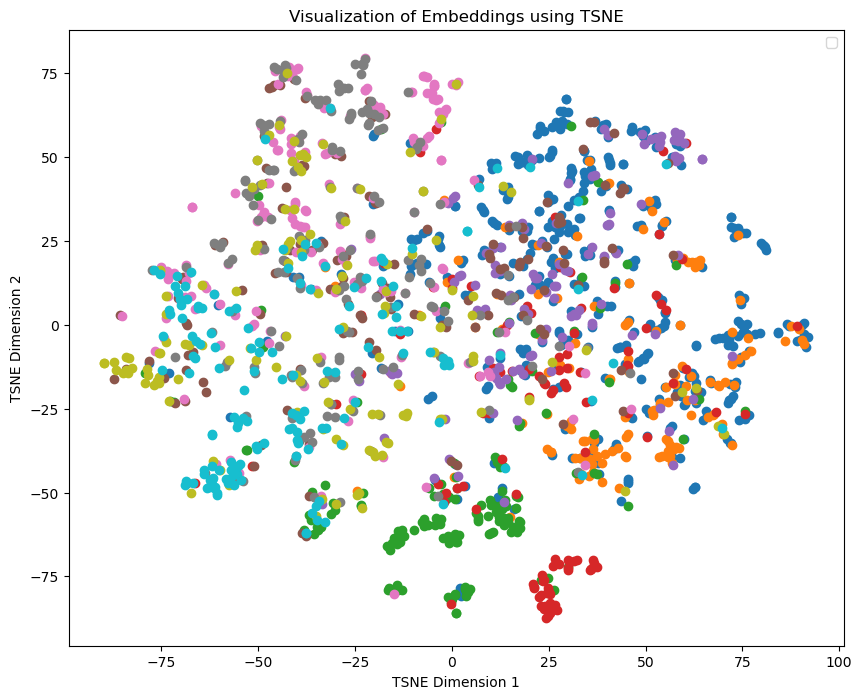

In [65]:
mode = 'TSNE'
reduced_embedding = reduce(embeddings, mode)

colormap = cm.get_cmap('tab10')
class_colors = [colormap(i/len(classes)) for i in range(len(classes))]

plt.figure(figsize=(10, 8))
for label in range(len(classes)):
    mask = np.array([l == label for l in labels])
    plt.scatter(reduced_embedding[mask, 0], reduced_embedding[mask, 1], color=class_colors[label])

plt.title(f'Visualization of Embeddings using {mode}')
plt.xlabel(f'{mode} Dimension 1')
plt.ylabel(f'{mode} Dimension 2')
plt.legend()
plt.show()